# Data Mining Project - part I
## Exploratory data analysis & Classification
### Author: Jakub Koral

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dython.nominal import associations
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, PrecisionRecallDisplay,
                             RocCurveDisplay, accuracy_score, precision_score,
                             recall_score)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold,
                                     cross_validate, train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from tqdm import tqdm
from xgboost import XGBClassifier

In [2]:
warnings.filterwarnings("ignore", message="The objective has been evaluated at this point before.")
paths = ["./plots", "./results"]
for PATH in paths:
    if not os.path.exists(PATH):
        os.makedirs(PATH)

## Exploratory data analysis

### Data preprocessing

In [3]:
X_raw = pd.read_csv("data/adult_uci.csv")

In [4]:
X_raw

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


We can see that for the 14th entry we have no information about the native country of a person marked by "?" sign. Let us see how many empty cells we have (marked by either NaN or "?").

In [5]:
X_raw.isnull().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

The number of empty cells compared to the number of all records is low, so we will drop them.

In [6]:
X = X_raw.copy()
X = X.replace("?", np.nan) # replacing "?" with NaNs
X = X.dropna(ignore_index=True) # dropping missing values
X.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [7]:
numeric_features = X.columns[X.dtypes == "int64"].tolist()
categorical_features = X.columns[X.dtypes == "object"].tolist()
no_income = list(set(categorical_features) - {"income"})

### Visualizing categorical features

Let us visualize categorical features

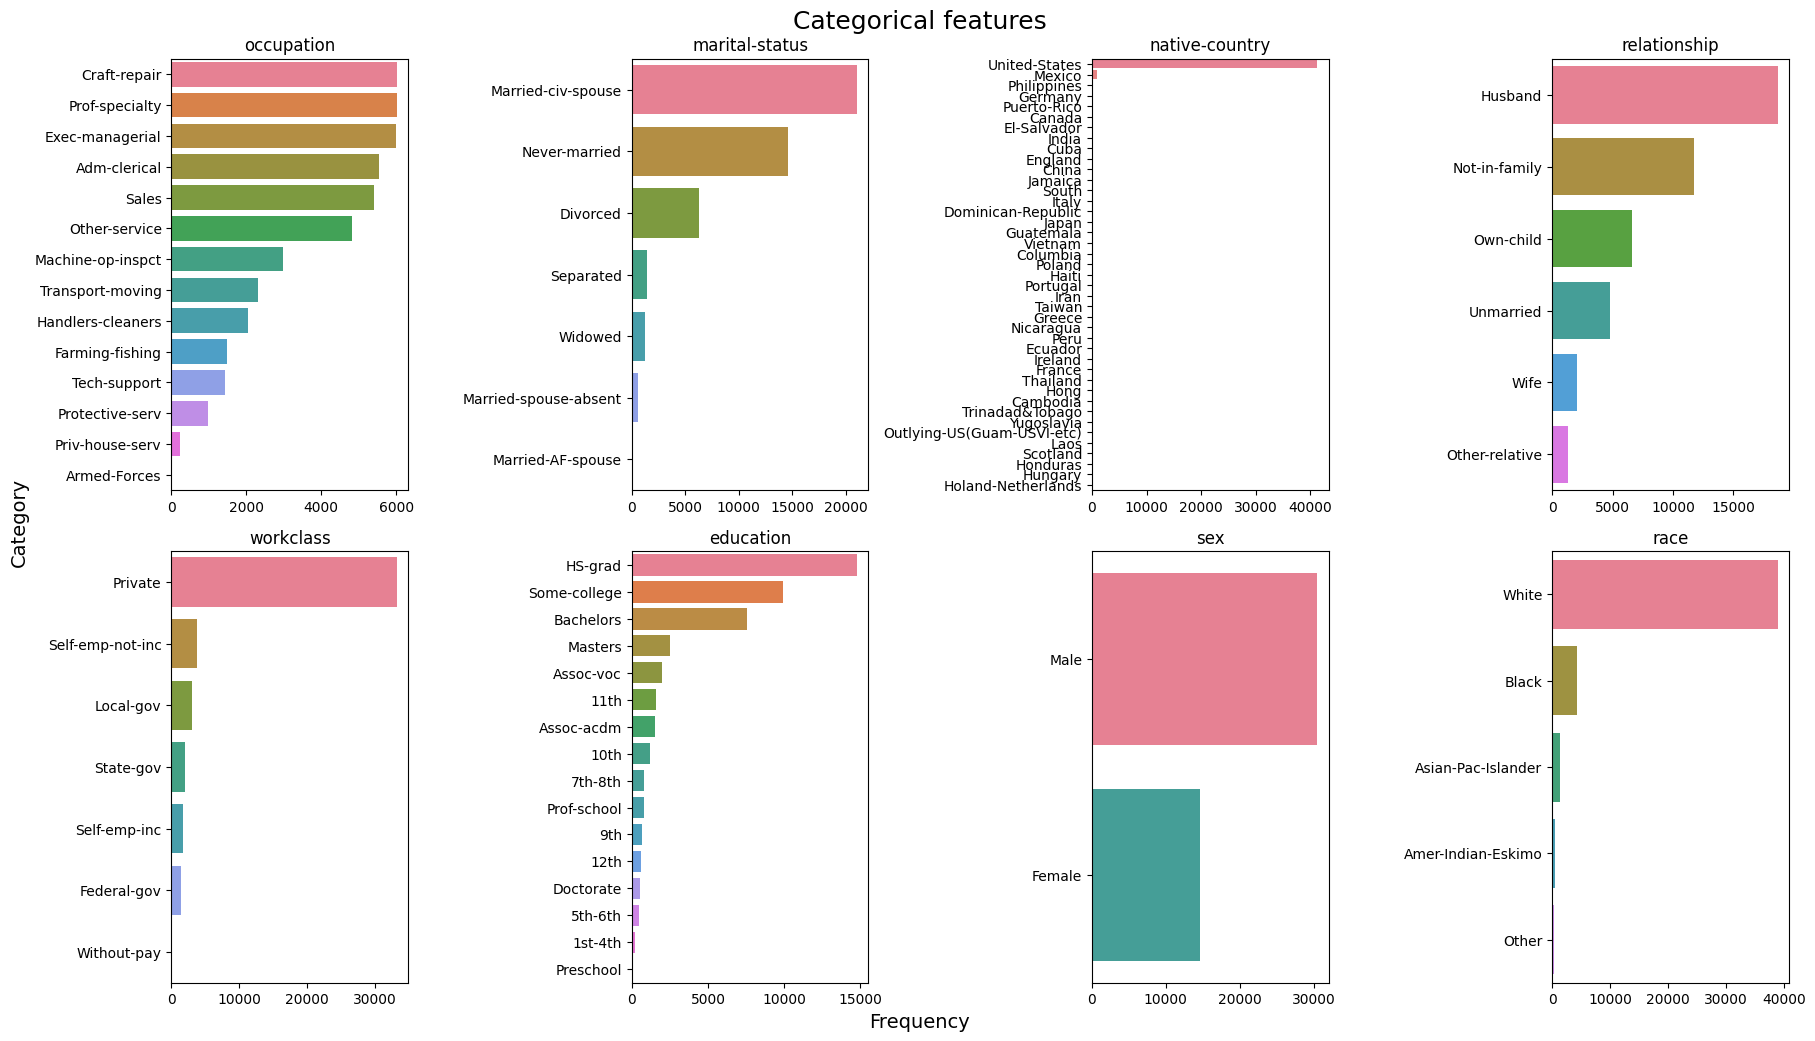

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))
for feature in no_income:
    sns.countplot(y=feature, hue=feature, data=X, 
                 palette=sns.color_palette("husl", len(X[feature].unique())), 
                 order=X[feature].value_counts().index,
                 hue_order=X[feature].value_counts().index,
                 ax=ax.ravel()[no_income.index(feature)])
    ax.ravel()[no_income.index(feature)].set_xlabel(None)
    ax.ravel()[no_income.index(feature)].set_ylabel(None)
    ax.ravel()[no_income.index(feature)].set_title(feature)

ax[0, 0].figure.text(0.5, 0.0, "Frequency", ha="center", va="center", size=14)
ax[0, 0].figure.text(0.0, 0.5, "Category", ha="center", va="center", rotation=90, size=14)
ax[0, 0].figure.text(0.5, 1.0, "Categorical features", ha="center", va="center", size=18)
plt.tight_layout()
plt.show()

We can observe, based on the "native-country" feature, that almost all people come from United States. There are very few people from other countries and teritotires. Thus we will combine "United-States" and "Outlying-US(Guam-USVI-etc)" to one category "US" and all other native countries to "non-US".

In [9]:
X.loc[(X["native-country"] == "Outlying-US(Guam-USVI-etc)") | (X["native-country"] == "United-States"), "native-country"] = "US"
X.loc[(X["native-country"] != "US"), "native-country"] = "non-US"

In [10]:
X["income"].unique()

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

It is also obvious that for "income" feature categories with "." and without should be combined.

In [11]:
X.loc[X["income"] == "<=50K.", "income"] = "<=50K"
X.loc[X["income"] == ">50K.", "income"] = ">50K"

Let us redraw the plot after this changes.

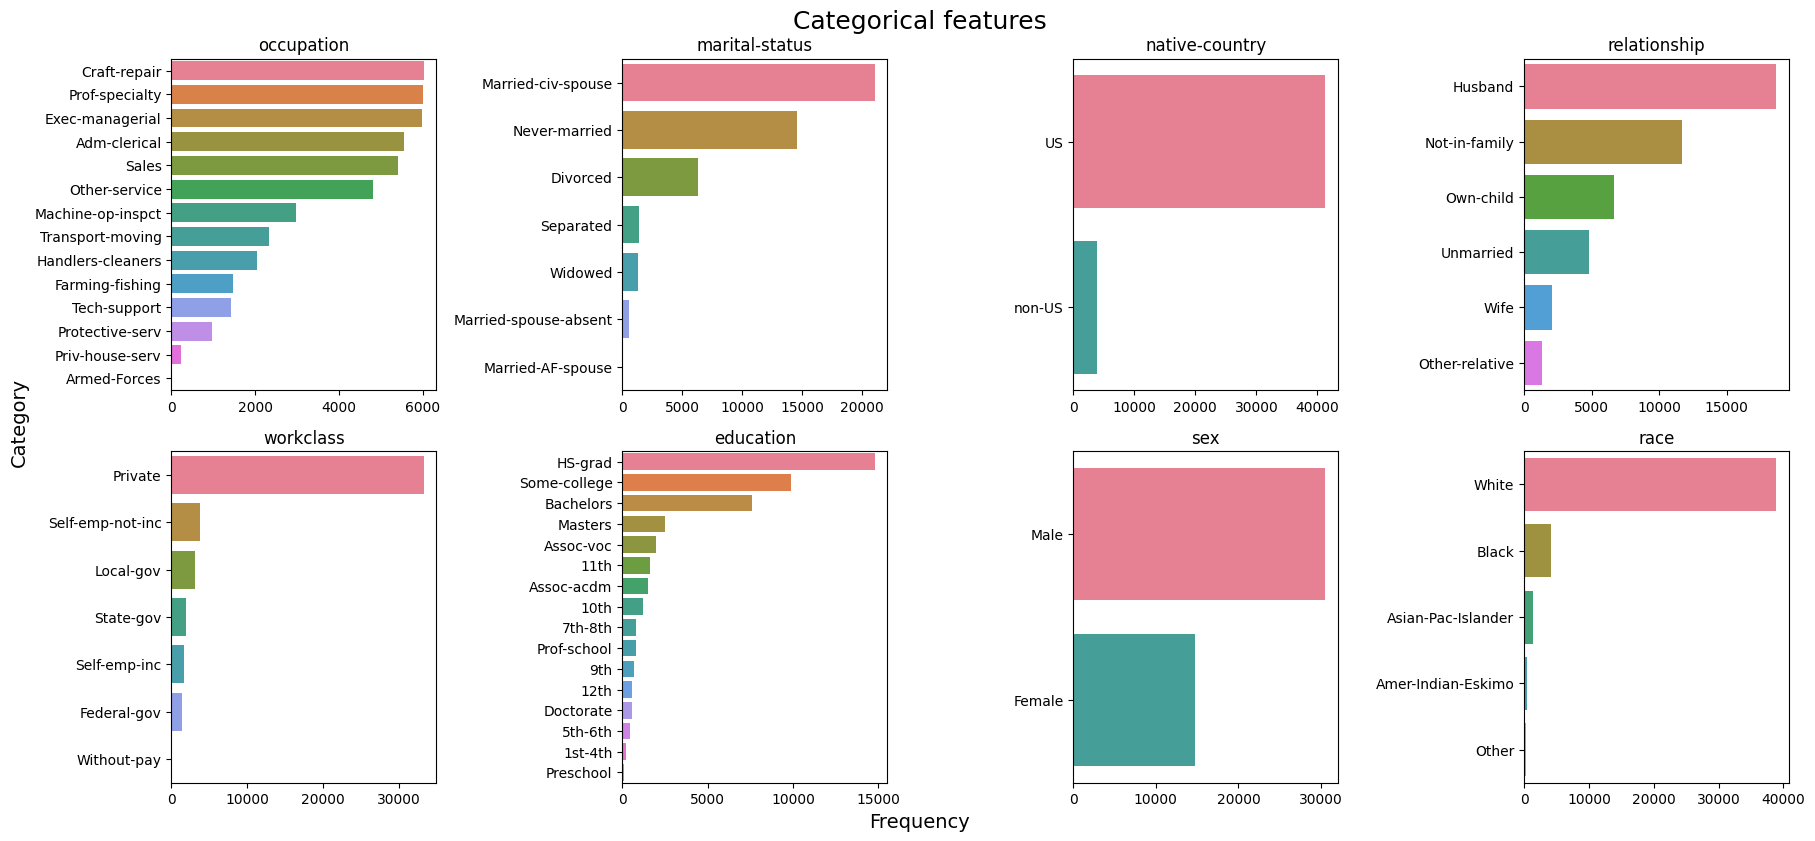

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
for feature in no_income:
    sns.countplot(y=feature, hue=feature, data=X, 
                 palette=sns.color_palette("husl", len(X[feature].unique())),
                 order=X[feature].value_counts().index,
                 hue_order=X[feature].value_counts().index,
                 ax=ax.ravel()[no_income.index(feature)])
    ax.ravel()[no_income.index(feature)].set_xlabel(None)
    ax.ravel()[no_income.index(feature)].set_ylabel(None)
    ax.ravel()[no_income.index(feature)].set_title(feature)

ax[0, 0].figure.text(0.5, 0.0, "Frequency", ha="center", va="center", size=14)
ax[0, 0].figure.text(0.0, 0.5, "Category", ha="center", va="center", rotation=90, size=14)
ax[0, 0].figure.text(0.5, 1.0, "Categorical features", ha="center", va="center", size=18)
plt.tight_layout()
plt.savefig("plots/categorical.pdf", bbox_inches="tight")
plt.show()

 Most individuals work in the private sector. Most of the people included in the census are white. The most common group in the population are high school graduates. There are more men than women in this data set. The most common native country is United States, which is no surprise, as the data comes from the US Census. 

Now we present categorical features subdivided by income.

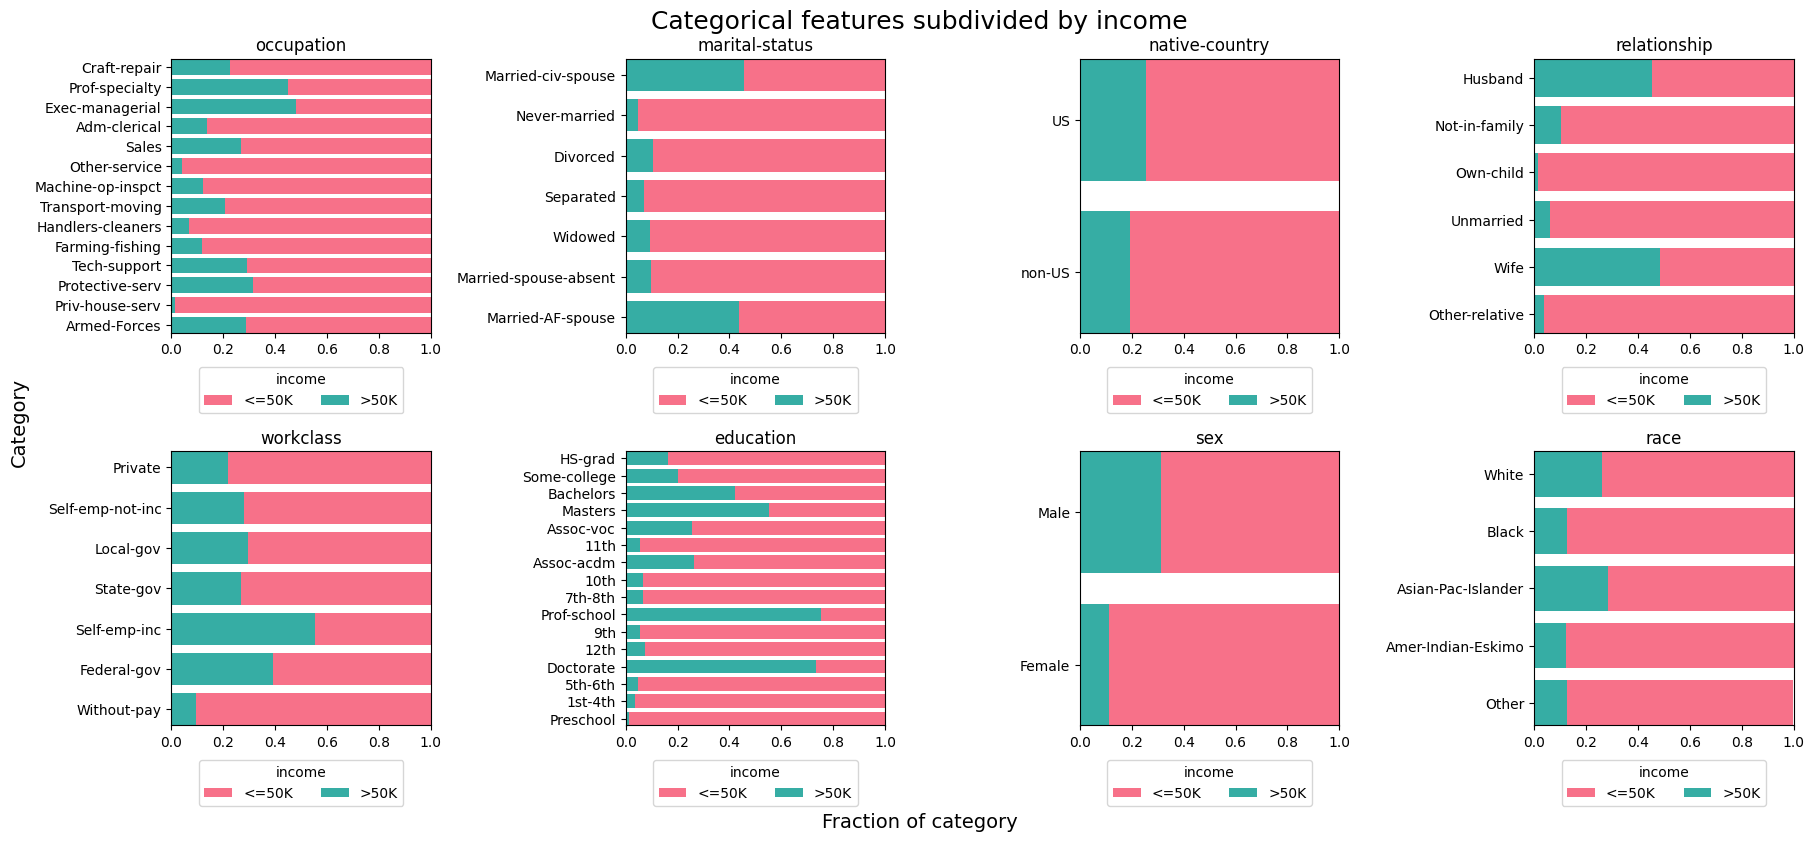

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
for feature in no_income:
    X2 = X.copy()
    X2[feature] = pd.Categorical(X2[feature], X2[feature].value_counts().index)
    sns.histplot(y=feature, hue="income", data=X2, multiple="fill", 
                 palette=sns.color_palette("husl", 2), edgecolor="none", 
                 alpha=1, shrink=0.8, ax=ax.ravel()[no_income.index(feature)])
    ax.ravel()[no_income.index(feature)].set_xlabel(None)
    ax.ravel()[no_income.index(feature)].set_ylabel(None)
    ax.ravel()[no_income.index(feature)].set_title(feature)
    sns.move_legend(ax.ravel()[no_income.index(feature)], "upper center",
    bbox_to_anchor=(0.5, -0.1), ncol=2)

ax[0, 0].figure.text(0.5, 0.0, "Fraction of category", ha="center", va="center", size=14)
ax[0, 0].figure.text(0.0, 0.5, "Category", ha="center", va="center", rotation=90, size=14)
ax[0, 0].figure.text(0.5, 1.0, "Categorical features subdivided by income", ha="center", va="center", size=18)

plt.tight_layout()
plt.savefig("plots/categorical_grouped.pdf", bbox_inches="tight")
plt.show()

There is an overrepresentation of self-employed incorporated among the wealthy. People with higher education are more likely to earn more than \$50,000 a year. Being married is connected with the higher probability of being more affluent. Percentage-wise, more men than women are wealthy. Individuals who work as specialists or executive managers have a higher chance of being rich.

### Visulizing numerical features

We pass the quantitaive features.

In [14]:
X[numeric_features].describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,4.522200e+04,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,1.897347e+05,10.118460,1101.430344,88.595418,40.938017
std,13.217870,1.056392e+05,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.173882e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783160e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.379260e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Most people do not report any gain or loss in capital. As expected most individuals work 40 hours per week.

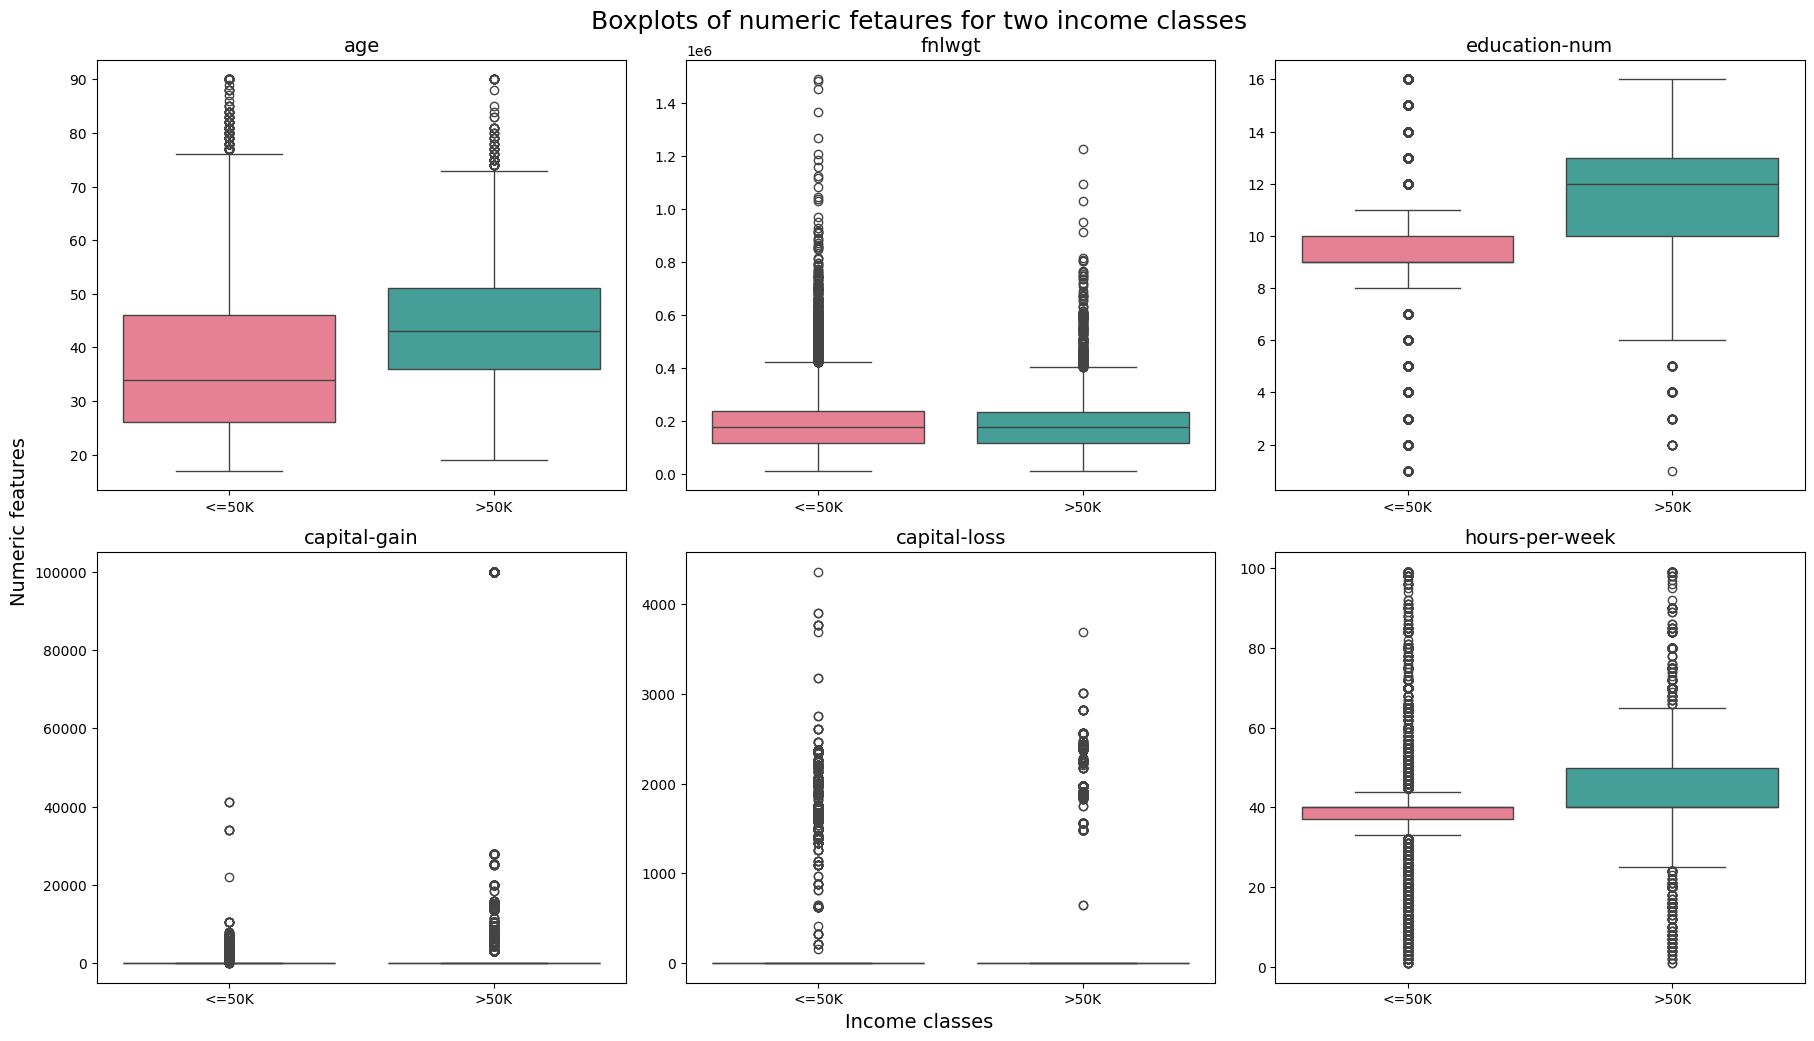

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
for i in range(len(numeric_features)):
    sns.boxplot(data=X, y=numeric_features[i], x="income", hue="income", palette=sns.color_palette("husl", 2), ax=ax.ravel()[i])
    ax.ravel()[i].set_ylabel(None)
    ax.ravel()[i].set_xlabel(None)
    ax.ravel()[i].set_title(numeric_features[i], size=14)
ax[0, 0].figure.text(0.5, 0.0, "Income classes", ha="center", va="center", size=14)
ax[0, 0].figure.text(0.0, 0.5, "Numeric features", ha="center", va="center", rotation=90, size=14)
ax[0, 0].figure.text(0.5, 1.0, "Boxplots of numeric fetaures for two income classes", ha="center", va="center", size=18)
plt.tight_layout()
plt.savefig("plots/numeric_all.pdf", bbox_inches="tight")
plt.show()


Among numeric characteristics, significant differences between two income groups are observed in age, number of years of education, and hours worked per week. The wealthy (i.e. people earning more than \$50,000 per year) are older, have higher education and work more than those with the annual income below \$50,000.

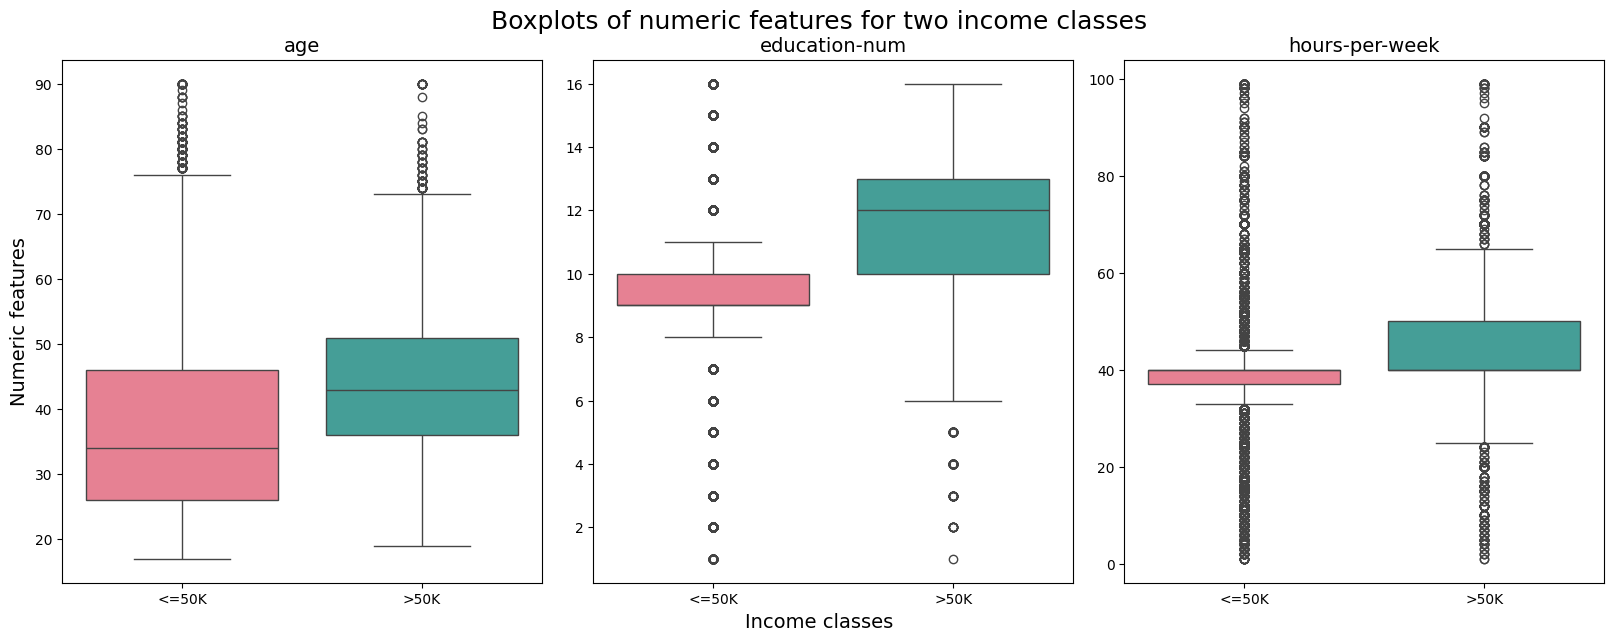

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

for i in range(len(["age", "education-num", "hours-per-week"])):
    sns.boxplot(data=X, y=["age", "education-num", "hours-per-week"][i], 
                x="income", hue="income", palette=sns.color_palette("husl", 2), ax=ax.ravel()[i])
    ax.ravel()[i].set_xlabel(None)
    ax.ravel()[i].set_ylabel(None)
    
    ax.ravel()[i].set_title(["age", "education-num", "hours-per-week"][i], size=14)
ax[0].figure.text(0.5, 0.0, "Income classes", ha="center", va="center", size=14)
ax[0].figure.text(0.0, 0.5, "Numeric features", ha="center", va="center", rotation=90, size=14)
ax[0].figure.text(0.5, 1.0, "Boxplots of numeric features for two income classes", ha="center", va="center", size=18)
plt.tight_layout()
plt.savefig("plots/numeric.pdf", bbox_inches="tight")
plt.show()


Both types of features are compared using violin plot. We can observe that the median number of years of education is higher for women in both income classes. Wealthy individuals whose native country is different from the United States have a higher median number of years of education. Richer men work more hours per week than the affluent women.

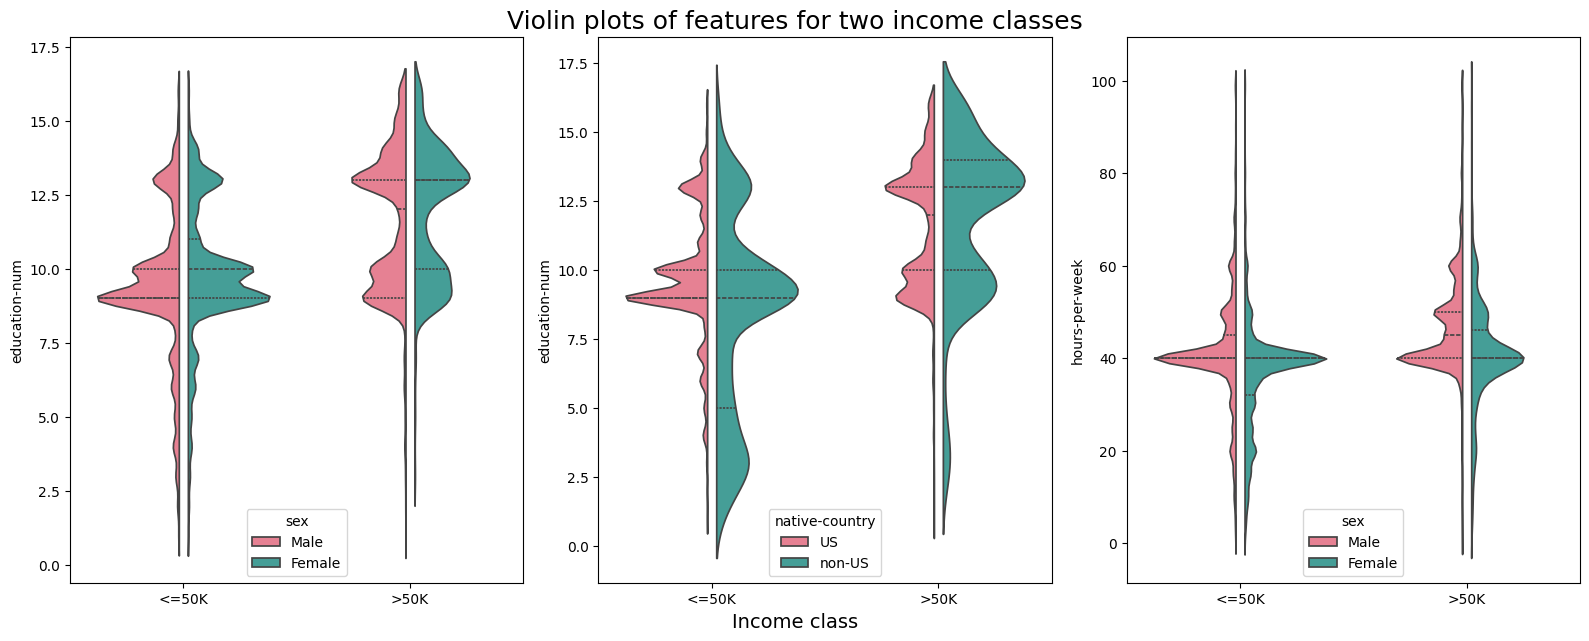

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
sns.violinplot(data=X, x="income", y="education-num", hue="sex", 
                    split=True, gap=.1, inner="quart", 
                    palette=sns.color_palette("husl", 2), ax=ax[0])
sns.violinplot(data=X, x="income", y="education-num", hue="native-country", 
                    split=True, gap=.1, inner="quart", 
                    palette=sns.color_palette("husl", 2), ax=ax[1])
sns.violinplot(data=X, x="income", y="hours-per-week", hue="sex", 
                    split=True, gap=.1, inner="quart", 
                    palette=sns.color_palette("husl", 2), ax=ax[2])
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[2].set_xlabel(None)
sns.move_legend(ax[0], "lower center")
sns.move_legend(ax[1], "lower center")
sns.move_legend(ax[2], "lower center")
ax[0].figure.text(0.5, 0.0, "Income class", ha="center", va="center", size=14)
ax[0].figure.text(0.5, 1.0, "Violin plots of features for two income classes", ha="center", va="center", size=18)
plt.tight_layout()
plt.savefig("plots/violin.pdf", bbox_inches="tight")
plt.show()

### Associations

Now we investigate associations between features.

c:\Users\jakub\AppData\Local\Programs\Python\Python312\Lib\site-packages\dython\nominal.py:708: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
c:\Users\jakub\AppData\Local\Programs\Python\Python312\Lib\site-packages\dython\nominal.py:709: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)


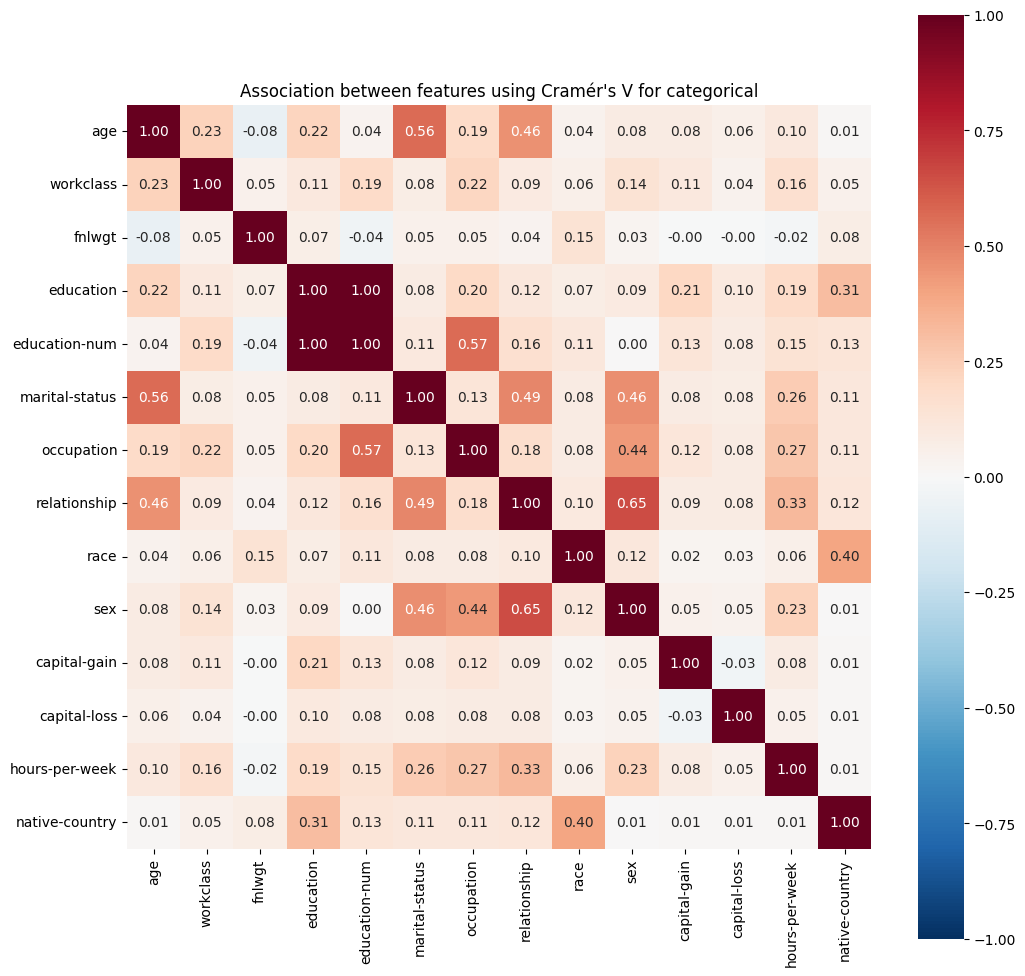

In [18]:
fig, ax = plt.subplots(figsize=(12, 12))

associations(X.iloc[:, :-1], numerical_columns=numeric_features, 
             nominal_columns=categorical_features,
             nom_nom_assoc="cramer", cmap = "RdBu_r", 
             ax=ax, 
             title="Association between features using Cramér's V for categorical",
             filename="plots/assoc_cramer_v.pdf")
plt.show()


We can see that education and education-num convey practically the same information, hence we drop education. Other relatively highly associated characteristics include: sex and relationship, occupation and education-num and age and marital status.

The alternative approach using the asymmetrical measure Theil's U is presented below.

c:\Users\jakub\AppData\Local\Programs\Python\Python312\Lib\site-packages\dython\nominal.py:708: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
c:\Users\jakub\AppData\Local\Programs\Python\Python312\Lib\site-packages\dython\nominal.py:709: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)


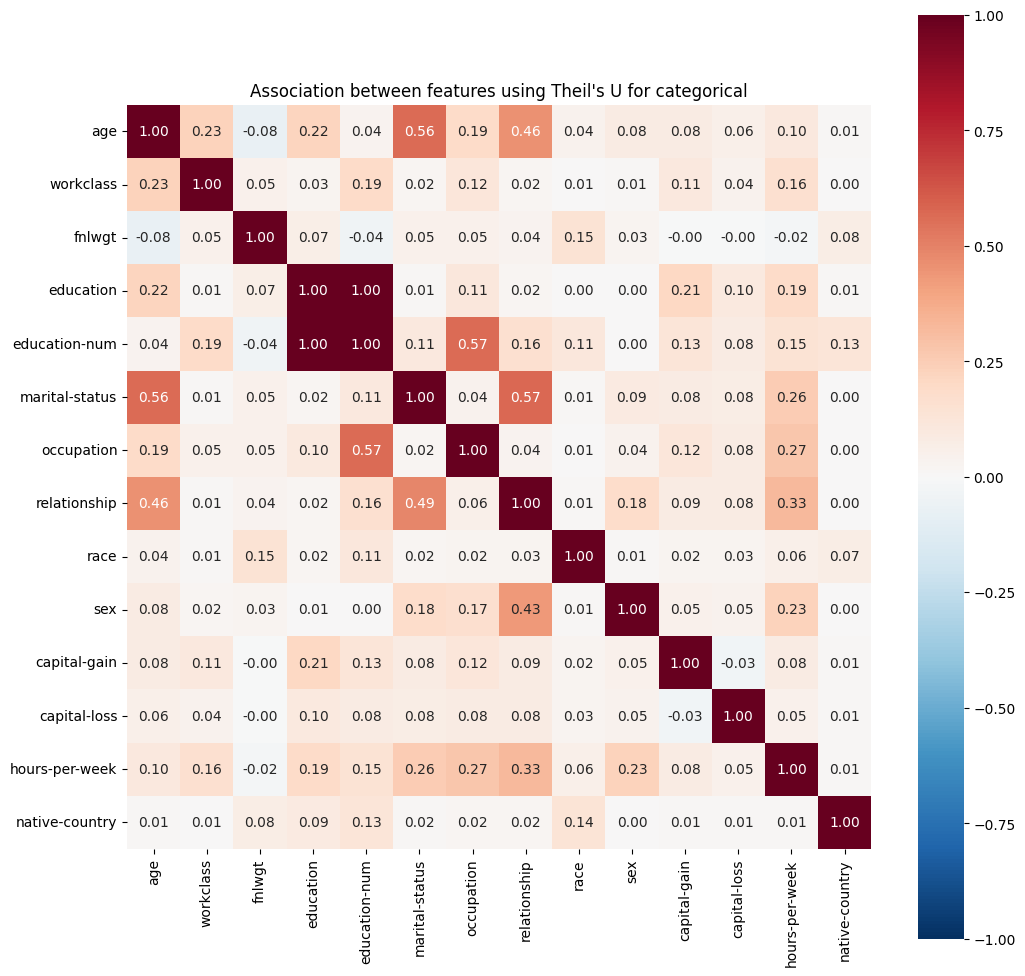

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))

associations(X.iloc[:, :-1], numerical_columns=numeric_features, 
             nominal_columns=categorical_features,
             nom_nom_assoc="theil", cmap = "RdBu_r", 
             ax=ax, 
             title="Association between features using Theil's U for categorical",
             filename="plots/assoc_theil_u.pdf")
plt.show()

## Classification

### Further data preprocessing

In [20]:
X.drop(columns=["education"], inplace=True) # dropping education
y = X["income"].map({"<=50K": 0, ">50K": 1}) # encoding prediction class
X.drop(columns=["income"], inplace=True)

one_hot_encoded = list(set(categorical_features) - {"education", "income"}) # one-hot encoding
scaler = StandardScaler() # standard scaling
X = pd.concat([pd.DataFrame(scaler.fit_transform(X[numeric_features]), 
                            columns=X[numeric_features].columns), 
                            pd.get_dummies(X[one_hot_encoded], drop_first=True)], 
                            axis=1)

### Fitting with default parameters

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [25]:
n_splits = 10
n_repeats = 10

models = [KNeighborsClassifier(),
          LinearDiscriminantAnalysis(),
          QuadraticDiscriminantAnalysis(),
          LogisticRegression(max_iter=1000), 
          DecisionTreeClassifier(), 
          RandomForestClassifier(), 
          XGBClassifier(), 
          ExtraTreesClassifier()]
names = ["KNN", "LDA", "QDA", "LR", "DT", "RF", "XGB", "XRT"]

results_acc = pd.DataFrame(columns=names, index=range(n_splits * n_repeats))
results_prec = pd.DataFrame(columns=names, index=range(n_splits * n_repeats))
results_rec = pd.DataFrame(columns=names, index=range(n_splits * n_repeats))

scoring = ["accuracy", "precision", "recall"]
kfold = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

for i in tqdm(range(len(models)), desc="Performing cross-validation"):
    if names[i] == "LDA" or names[i] == "QDA":
        cv_results = cross_validate(models[i], X_train[numeric_features], y_train, cv=kfold, scoring=scoring, n_jobs=-1)
    else:
        cv_results = cross_validate(models[i], X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
    results_acc[names[i]] = cv_results["test_accuracy"]
    results_prec[names[i]] = cv_results["test_precision"]
    results_rec[names[i]] = cv_results["test_recall"]

results_acc.to_csv("results/initial_accuracy.csv", index=False)
results_prec.to_csv("results/initial_precision.csv", index=False)
results_rec.to_csv("results/initial_recall.csv", index=False)

In [22]:
# results_acc = pd.read_csv("results/initial_accuracy.csv")
# results_prec = pd.read_csv("results/initial_precision.csv")
# results_rec = pd.read_csv("results/initial_recall.csv")

In [23]:
results_f1 = 2 * (results_prec * results_rec) / (results_prec + results_rec)

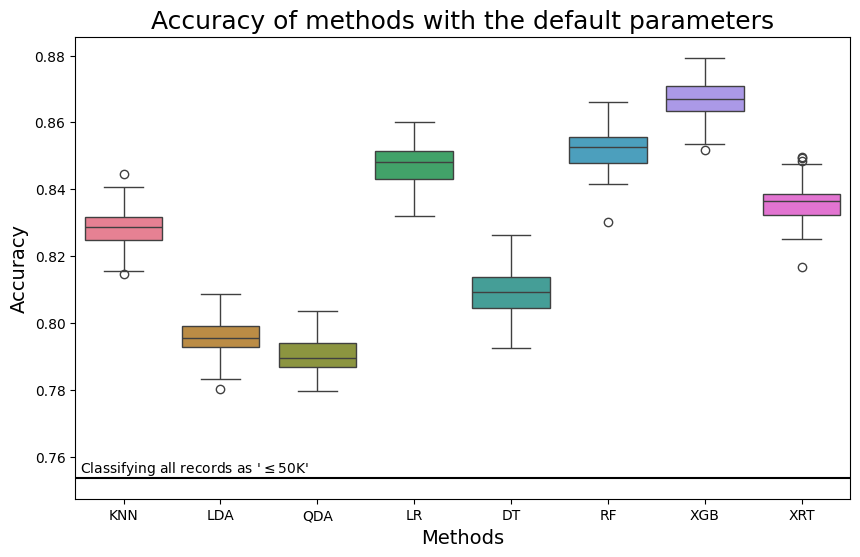

In [26]:
fig = plt.figure(figsize=(10, 6))
sns.boxplot(data=results_acc, palette=sns.color_palette("husl", len(names)))
plt.title("Accuracy of methods with the default parameters", size=18)
plt.xlabel("Methods", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.axhline(y_train.value_counts(normalize=True)[0], c="k")
fig.text(0.13, 0.16, r"Classifying all records as '$\leq$50K'", ha="left", va="center", size=10)
plt.savefig("plots/initial_acc.pdf")
plt.show()

All methods perform better than classifying all records as "$<$=50K". The best results are obtained for the XGB algorithm.

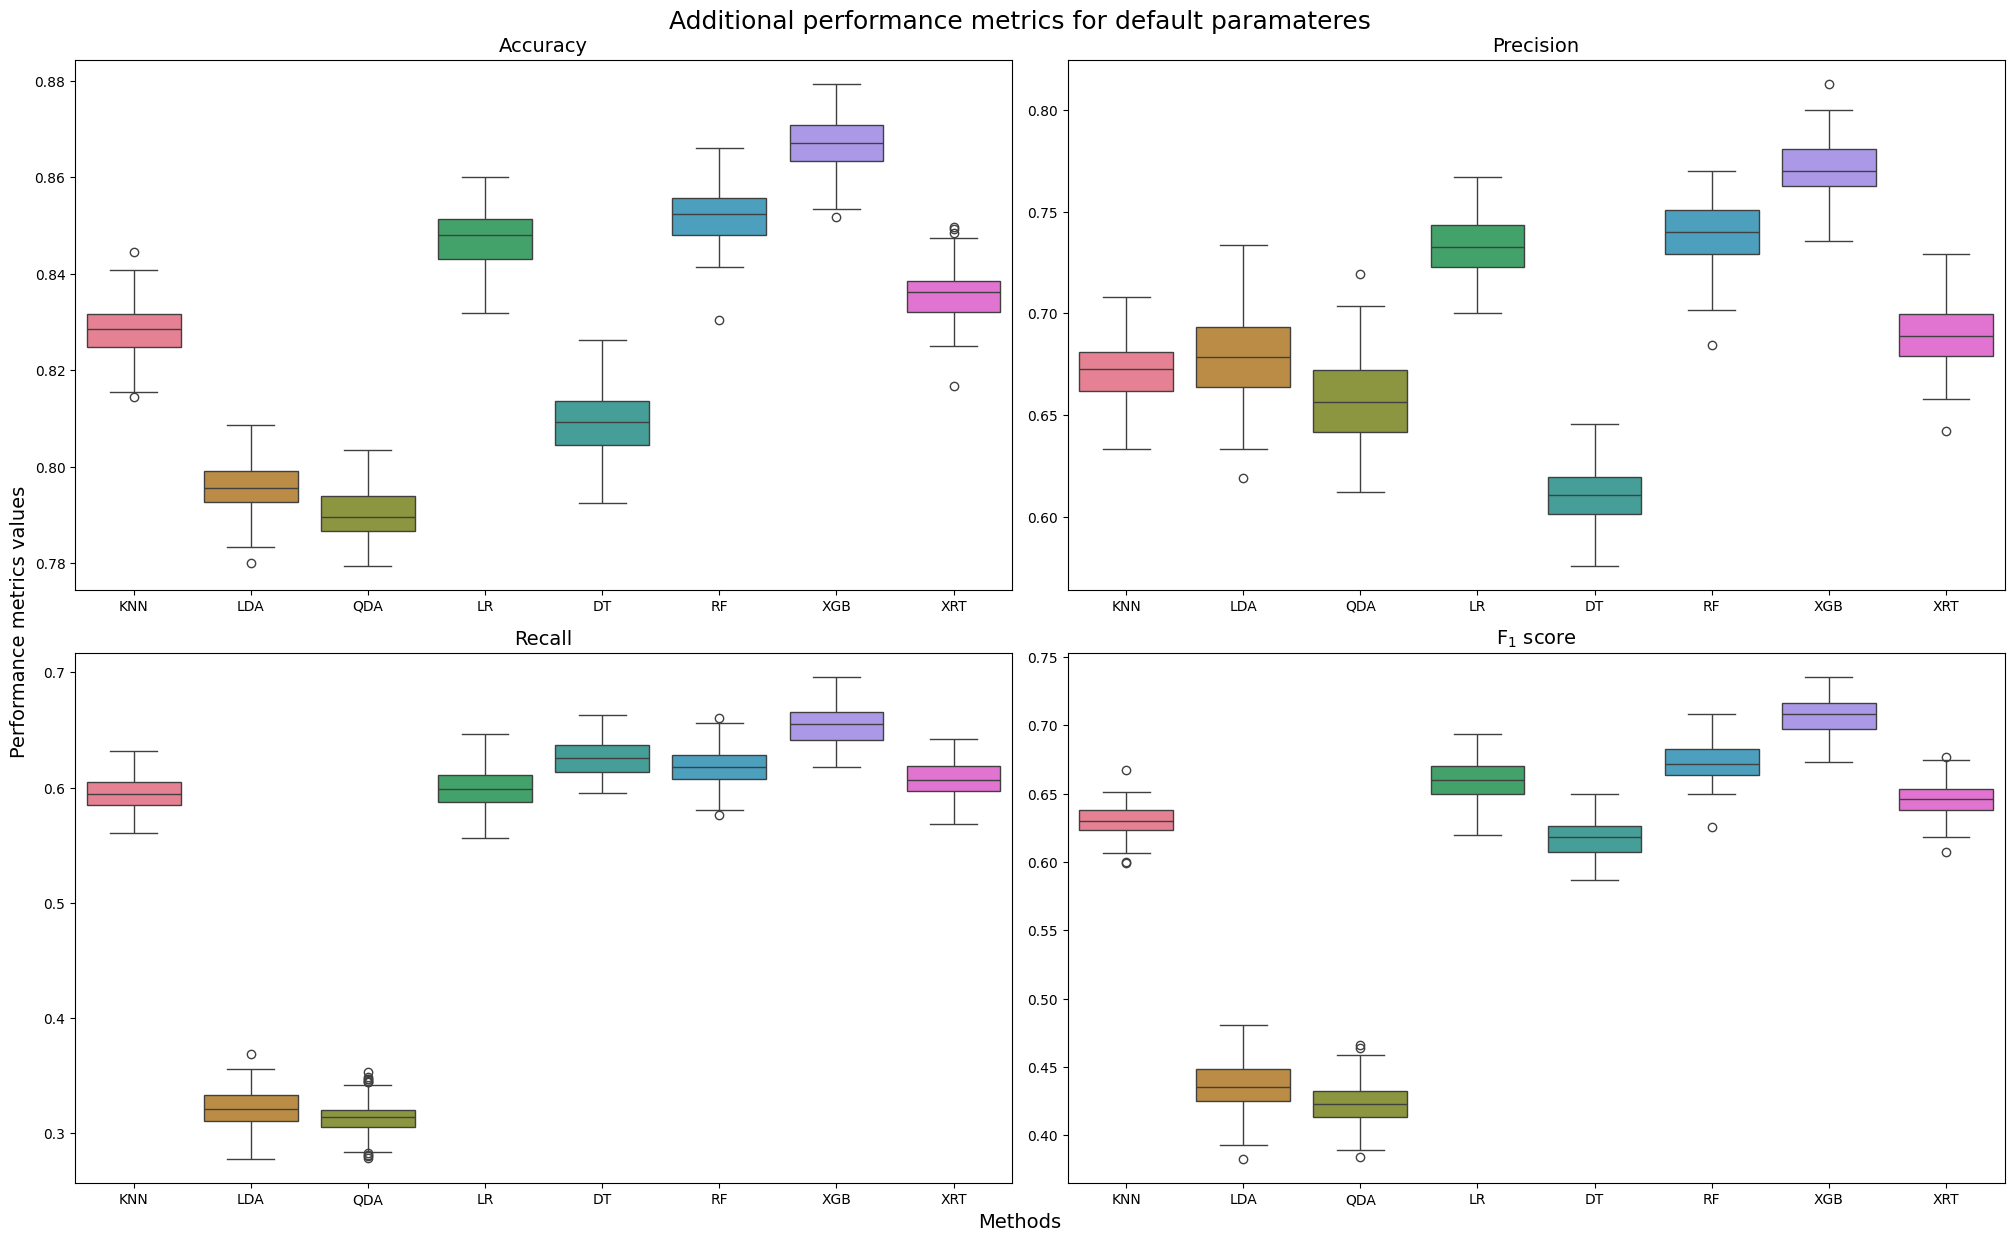

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
sns.boxplot(data=results_acc, palette=sns.color_palette("husl", len(names)), ax=ax[0, 0])
ax[0, 0].set_title("Accuracy", size=14)
sns.boxplot(data=results_prec, palette=sns.color_palette("husl", len(names)), ax=ax[0, 1])
ax[0, 1].set_title("Precision", size=14)
sns.boxplot(data=results_rec, palette=sns.color_palette("husl", len(names)), ax=ax[1, 0])
ax[1, 0].set_title("Recall", size=14)
sns.boxplot(data=results_f1, palette=sns.color_palette("husl", len(names)), ax=ax[1, 1])
ax[1, 1].set_title(r"F$_1$ score", size=14)
ax[0, 0].figure.text(0.5, 0.0, "Methods", ha="center", va="center", size=14)
ax[0, 0].figure.text(0.00, 0.5, "Performance metrics values", ha="center", va="center", rotation=90, size=14)
ax[0, 0].figure.text(0.5, 1.0, "Additional performance metrics for default paramateres", ha="center", va="center", size=18)
plt.tight_layout()
plt.savefig("plots/initial.pdf")
plt.show()

In [28]:
models = [KNeighborsClassifier(),
          LinearDiscriminantAnalysis(),
          QuadraticDiscriminantAnalysis(),
          LogisticRegression(max_iter=1000), 
          DecisionTreeClassifier(), 
          RandomForestClassifier(),
          XGBClassifier(), 
          ExtraTreesClassifier()]
names = ["KNN", "LDA", "QDA", "LR", "DT", "RF", "XGB", "XRT"]

results_predict_default = pd.DataFrame(index=names, columns=["accuracy", "precision", "recall"])

for i in tqdm(range(len(models)), desc="Scoring performance"):
    if names[i] == "LDA" or names[i] == "QDA":
        y_pred = models[i].fit(X_train[numeric_features], y_train).predict(X_test[numeric_features])
    else:
        y_pred = models[i].fit(X_train, y_train).predict(X_test)
    results_predict_default.loc[names[i], "accuracy"] = accuracy_score(y_test, y_pred)
    results_predict_default.loc[names[i], "precision"] = precision_score(y_test, y_pred)
    results_predict_default.loc[names[i], "recall"] = recall_score(y_test, y_pred)

results_predict_default["f1"] = 2 * (results_predict_default["precision"] * results_predict_default["recall"]) /\
      (results_predict_default["precision"] + results_predict_default["recall"])

Scoring performance: 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


In [29]:
results_predict_default

,accuracy,precision,recall,f1
KNN,0.834451,0.694751,0.609206,0.649172
LDA,0.798039,0.709034,0.333627,0.453748
QDA,0.784551,0.655414,0.301671,0.41317
LR,0.84735,0.738604,0.608033,0.666988
DT,0.809096,0.616059,0.638816,0.627231
RF,0.854942,0.751131,0.632659,0.686824
XGB,0.8702,0.785073,0.66608,0.720698
XRT,0.839685,0.704907,0.623278,0.661584


Scoring performance: 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


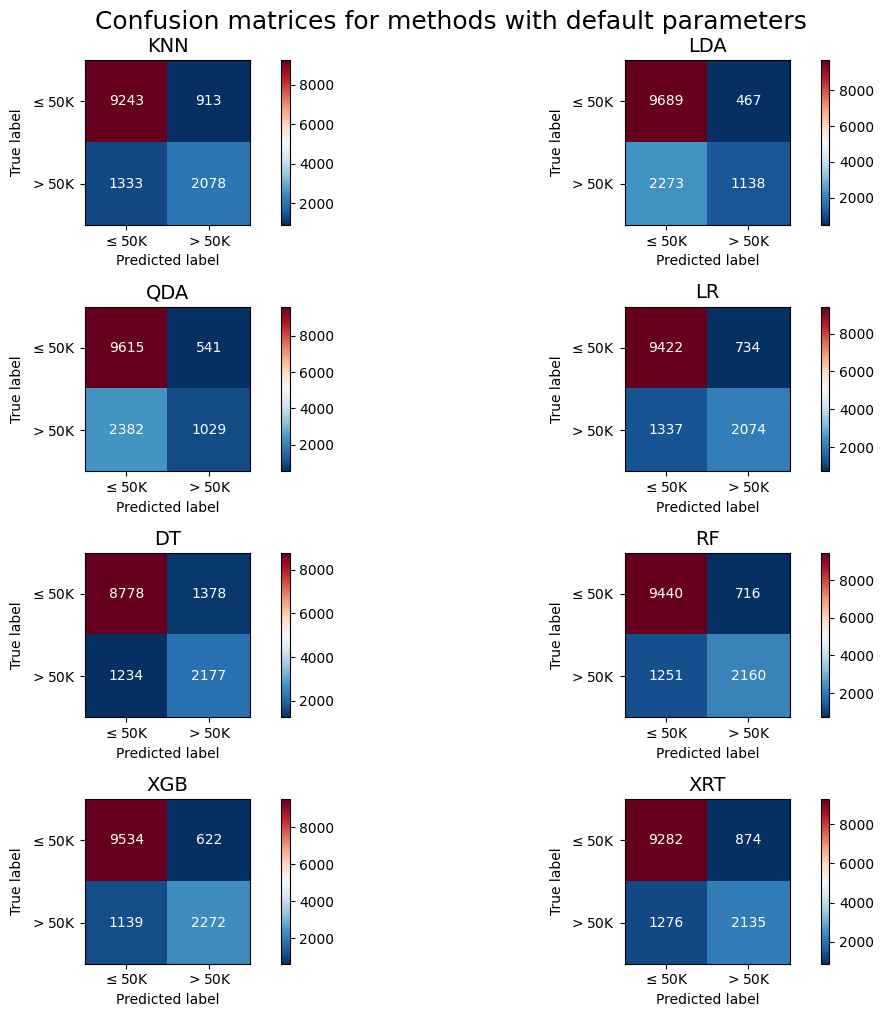

In [33]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(12, 10))

for i in tqdm(range(len(models)), desc="Scoring performance"):
    if names[i] == "LDA" or names[i] == "QDA":
        y_pred = models[i].fit(X_train[numeric_features], y_train).predict(X_test[numeric_features])
    else:
        y_pred = models[i].fit(X_train, y_train).predict(X_test)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax.ravel()[i], cmap="RdBu_r", text_kw={"color": "w"}, display_labels=[r"$\leq$50K", r"$>$50K"])
    ax.ravel()[i].set_title(names[i], size=14)

ax[0, 0].figure.text(0.6, 1.0, "Confusion matrices for methods with default parameters", ha="center", va="center", size=18)
plt.tight_layout()
plt.savefig("plots/confusion_default.pdf", bbox_inches="tight")
plt.show()

Scoring performance:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring performance: 100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


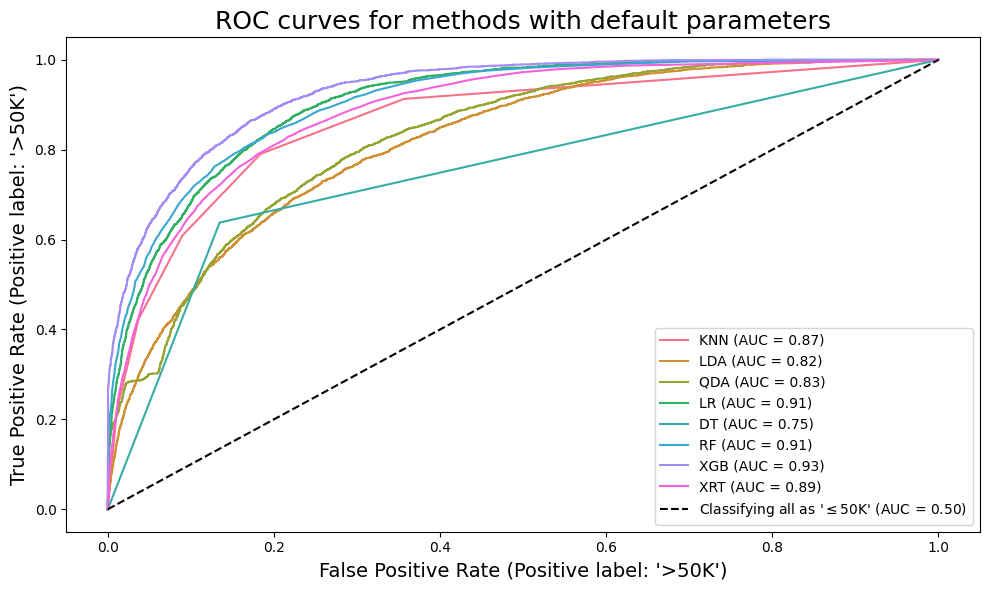

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in tqdm(range(len(models)), desc="Scoring performance"):
    if names[i] == "LDA" or names[i] == "QDA":
        clf = models[i].fit(X_train[numeric_features], y_train)
        RocCurveDisplay.from_estimator(clf, X_test[numeric_features], y_test, 
                                       ax=ax, name=names[i], 
                                       color=sns.color_palette("husl", len(names))[i])
    else:
        clf = models[i].fit(X_train, y_train)
        RocCurveDisplay.from_estimator(clf, X_test, y_test, 
                                       ax=ax, name=names[i], 
                                       color=sns.color_palette("husl", len(names))[i])

dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
RocCurveDisplay.from_estimator(dummy_clf, X_test, y_test, ax=ax, 
                               name=r"Classifying all as '$\leq$50K'", 
                               color="k", linestyle="--")


ax.set_title("ROC curves for methods with default parameters", size=18)
ax.set_xlabel("False Positive Rate (Positive label: '>50K')", size=14)
ax.set_ylabel("True Positive Rate (Positive label: '>50K')", size=14)

plt.tight_layout()
plt.savefig("plots/roc_default.pdf", bbox_inches="tight")
plt.show()

Scoring performance:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring performance: 100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


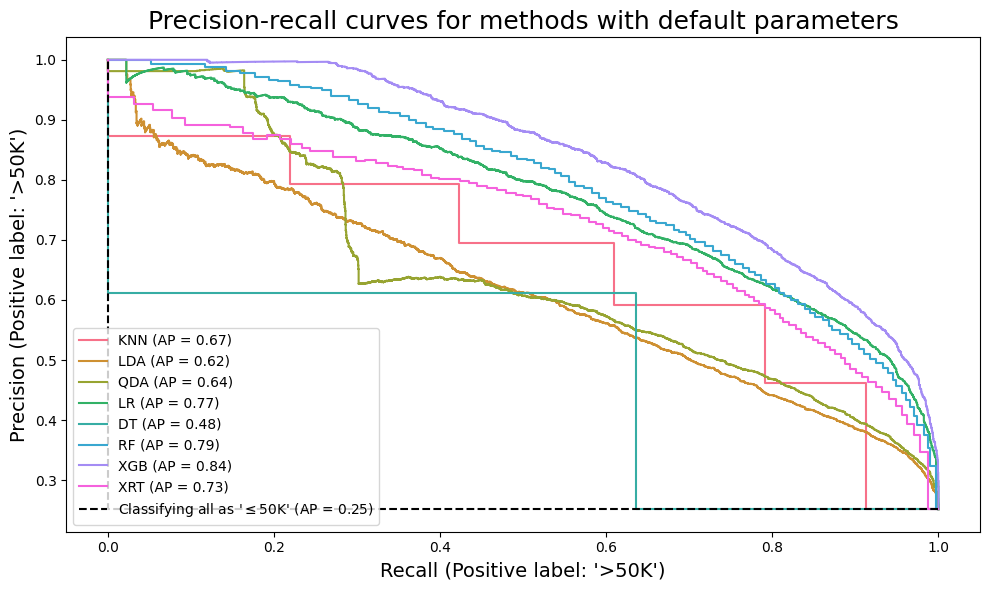

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in tqdm(range(len(models)), desc="Scoring performance"):
    if names[i] == "LDA" or names[i] == "QDA":
        clf = models[i].fit(X_train[numeric_features], y_train)
        PrecisionRecallDisplay.from_estimator(clf, X_test[numeric_features], y_test, 
                                              ax=ax, name=names[i], 
                                              color=sns.color_palette("husl", len(names))[i])
    else:
        clf = models[i].fit(X_train, y_train)
        PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, 
                                              ax=ax, name=names[i], 
                                              color=sns.color_palette("husl", len(names))[i])

dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
PrecisionRecallDisplay.from_estimator(dummy_clf, X_test, y_test, ax=ax, 
                                      name=r"Classifying all as '$\leq$50K'", 
                                      color="k", linestyle="--")


ax.set_title("Precision-recall curves for methods with default parameters", size=18)
ax.set_xlabel("Recall (Positive label: '>50K')", size=14)
ax.set_ylabel("Precision (Positive label: '>50K')", size=14)
plt.tight_layout()
plt.savefig("plots/prc_default.pdf", bbox_inches="tight")
plt.show()


### Model tunning

In [46]:
def model_tuning(estimator, search_spaces, bayes=True, n_splits = 10, n_repeats = 10):

    kfold = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    if bayes:
        grid_search = BayesSearchCV(estimator=estimator, search_spaces=search_spaces, cv=kfold, scoring="accuracy", n_jobs=-1)
    else:
        grid_search = GridSearchCV(estimator=estimator, param_grid=search_spaces, cv=kfold, scoring="accuracy", n_jobs=-1)
    fit_tunned = grid_search.fit(X_train, y_train.values.ravel())

    results_tuned = np.array([fit_tunned.cv_results_[f"split{i}_test_score"][fit_tunned.best_index_] for i in range(n_splits * n_repeats)])

    return results_tuned, fit_tunned.best_params_

In [41]:
results_tuned = pd.DataFrame(columns=["KNN", "DT", "RF", "XGB", "XRT"])

#### K-Nearest Neighbours

In [208]:
results_tuned_KNN, KNN_params = model_tuning(KNeighborsClassifier(), 
                                              {"n_neighbors": list(range(1, 52, 2))},
                                               bayes=False)
results_tuned["KNN"] = results_tuned_KNN
KNN_params

{'n_neighbors': 31}

#### Decision Trees

In [166]:
results_tuned_DT, DT_params = model_tuning(DecisionTreeClassifier(), 
                                              {"criterion": ["gini", "entropy", "log_loss"],
                                               "splitter": ["best", "random"],
                                               "max_depth": list(range(1, 21)),
                                               "max_features": ["sqrt", "log2"]},
                                               bayes=False)

results_tuned["DT"] = results_tuned_DT
DT_params

{'criterion': 'log_loss',
 'max_depth': 14,
 'max_features': 'sqrt',
 'splitter': 'best'}

##### Logistic Regression

In [213]:
results_tuned_LR, LR_params = model_tuning(LogisticRegression(max_iter=1000, solver="newton-cg"), 
                                            {"penalty": ["l2", None],
                                             "C": np.arange(0.1, 1.1, 0.1)}, 
                                             bayes=False)
results_tuned["LR"] = results_tuned_LR
LR_params, results_tuned_LR.mean()

({'C': 0.2, 'penalty': 'l2'}, 0.8477584654888681)

#### XGBoost

In [98]:
results_tuned_XGB, XGB_params = model_tuning(XGBClassifier(), 
                                              {"n_estimators": Integer(1, 1000),
                                               "learning_rate": Real(0.005, 1.0, prior="log-uniform")})
results_tuned["XGB"] = results_tuned_XGB
XGB_params

OrderedDict([('learning_rate', 0.014694908380105723), ('n_estimators', 948)])

#### Random forest

In [216]:
results_tuned_RF, RF_params = model_tuning(RandomForestClassifier(), 
                                              {"n_estimators": [5, 10, 20, 50, 100],
                                               "max_depth": [5, 10, 20],
                                               "max_features": ["sqrt", "log2"]},
                                               bayes=False)

results_tuned["RF"] = results_tuned_RF
RF_params

{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}

#### Extremely Randomized Trees

In [218]:
results_tuned_XRT, XRT_params = model_tuning(ExtraTreesClassifier(), 
                                              {"n_estimators": [5, 10, 20, 50, 100],
                                               "max_depth": [5, 10, 20],
                                               "max_features": ["sqrt", "log2"]},
                                               bayes=False)

results_tuned["XRT"] = results_tuned_XRT
XRT_params

{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}

In [205]:
results_tuned.to_csv("results/tuned.csv", index=False)

### Comparing models

In [3]:
results_tuned = pd.read_csv("results/tuned.csv")
results_tuned["parameters"] = "tuned"
results_acc = pd.read_csv("results/initial_accuracy.csv")
results_initial = results_acc[["KNN", "DT", "RF", "XGB", "XRT"]].copy()
results_initial["parameters"] = "default"
results_final_acc = pd.melt(pd.concat([results_initial, results_tuned], ignore_index=True), "parameters", var_name="method", value_name="accuracy")
results_final_acc.groupby(by=["method", "parameters"]).describe()

accuracy                                                    \
                     count      mean       std       min       25%       50%   
method parameters                                                              
DT     default       100.0  0.809117  0.006940  0.792101  0.805101  0.809667   
       tuned         100.0  0.838345  0.007531  0.817751  0.834097  0.839021   
KNN    default       100.0  0.828302  0.005276  0.814534  0.824895  0.828621   
       tuned         100.0  0.841349  0.005849  0.822117  0.837283  0.841074   
RF     default       100.0  0.852263  0.006195  0.828752  0.847982  0.852946   
       tuned         100.0  0.859997  0.005458  0.844550  0.857188  0.859760   
XGB    default       100.0  0.866669  0.005613  0.851817  0.863439  0.867141   
       tuned         100.0  0.869306  0.005769  0.853397  0.865672  0.869551   
XRT    default       100.0  0.835861  0.006378  0.813586  0.832162  0.835729   
       tuned         100.0  0.848441  0.005611  0.831912  0.844866  0.848547   

                                       
                        75%       max  
method parameters                      
DT     default     0.814040  0.828120  
       tuned       0.843049  0.857233  
KNN    default     0.831609  0.844599  
       tuned       0.845194  0.853759  
RF     default     0.856353  0.867025  
       tuned       0.863392  0.875237  
XGB    default     0.870774  0.879343  
       tuned       0.873628  0.879343  
XRT    default     0.840559  0.853127  
       tuned       0.851548  0.861023

 The performance of all algorithms is enhanced. The greatest improvement is observed for the DT classifier. Again, the best results are obtained for the XGB method.

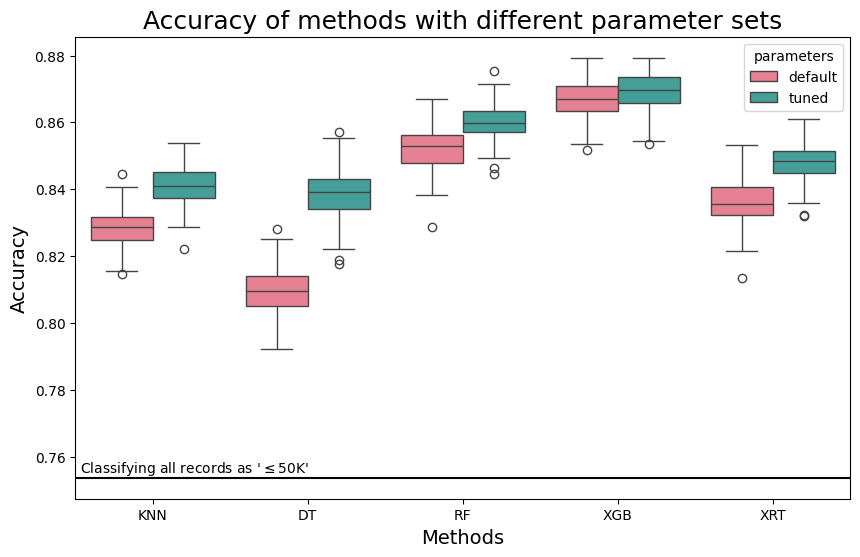

In [121]:
fig = plt.figure(figsize=(10, 6))
sns.boxplot(data=results_final_acc, x="method", y="accuracy", hue="parameters", palette=sns.color_palette("husl", 2))
plt.title("Accuracy of methods with different parameter sets", size=18)
plt.xlabel("Methods", size=14)
plt.ylabel("Accuracy", size=14)
plt.axhline(y_train.value_counts(normalize=True)[0], c="k")
fig.text(0.13, 0.16, r"Classifying all records as '$\leq$50K'", ha="left", va="center", size=10)
plt.savefig("plots/comparison.pdf")
plt.show()

### Final fit

In [22]:
models = [KNeighborsClassifier(n_neighbors=31),
          LinearDiscriminantAnalysis(),
          QuadraticDiscriminantAnalysis(),
          LogisticRegression(max_iter=1000), 
          DecisionTreeClassifier(criterion='log_loss', max_depth=14, max_features='sqrt', splitter='best'), 
          RandomForestClassifier(n_estimators=100, max_depth=20, max_features='sqrt'),
          XGBClassifier(n_estimators=948, learning_rate=0.014694908380105723), 
          ExtraTreesClassifier(n_estimators=100, max_depth=20, max_features='sqrt')]
names = ["KNN", "LDA", "QDA", "LR", "DT", "RF", "XGB", "XRT"]

results_predict = pd.DataFrame(index=names, columns=["accuracy", "precision", "recall"])

for i in tqdm(range(len(models)), desc="Scoring performance"):
    if names[i] == "LDA" or names[i] == "QDA":
        y_pred = models[i].fit(X_train[numeric_features], y_train).predict(X_test[numeric_features])
    else:
        y_pred = models[i].fit(X_train, y_train).predict(X_test)
    results_predict.loc[names[i], "accuracy"] = accuracy_score(y_test, y_pred)
    results_predict.loc[names[i], "precision"] = precision_score(y_test, y_pred)
    results_predict.loc[names[i], "recall"] = recall_score(y_test, y_pred)

results_predict["f1"] = 2 * (results_predict["precision"] * results_predict["recall"]) /\
      (results_predict["precision"] + results_predict["recall"])

Scoring performance: 100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


In [23]:
results_predict

,accuracy,precision,recall,f1
KNN,0.848161,0.735448,0.618587,0.671975
LDA,0.798039,0.709034,0.333627,0.453748
QDA,0.784551,0.655414,0.301671,0.41317
LR,0.84735,0.738604,0.608033,0.666988
DT,0.847424,0.756405,0.579889,0.656489
RF,0.862092,0.795245,0.608033,0.689151
XGB,0.872337,0.798012,0.659044,0.721901
XRT,0.852805,0.767196,0.595133,0.670299


The highest value for every performance metric is achieved using the XGB method.

Scoring performance:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring performance: 100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


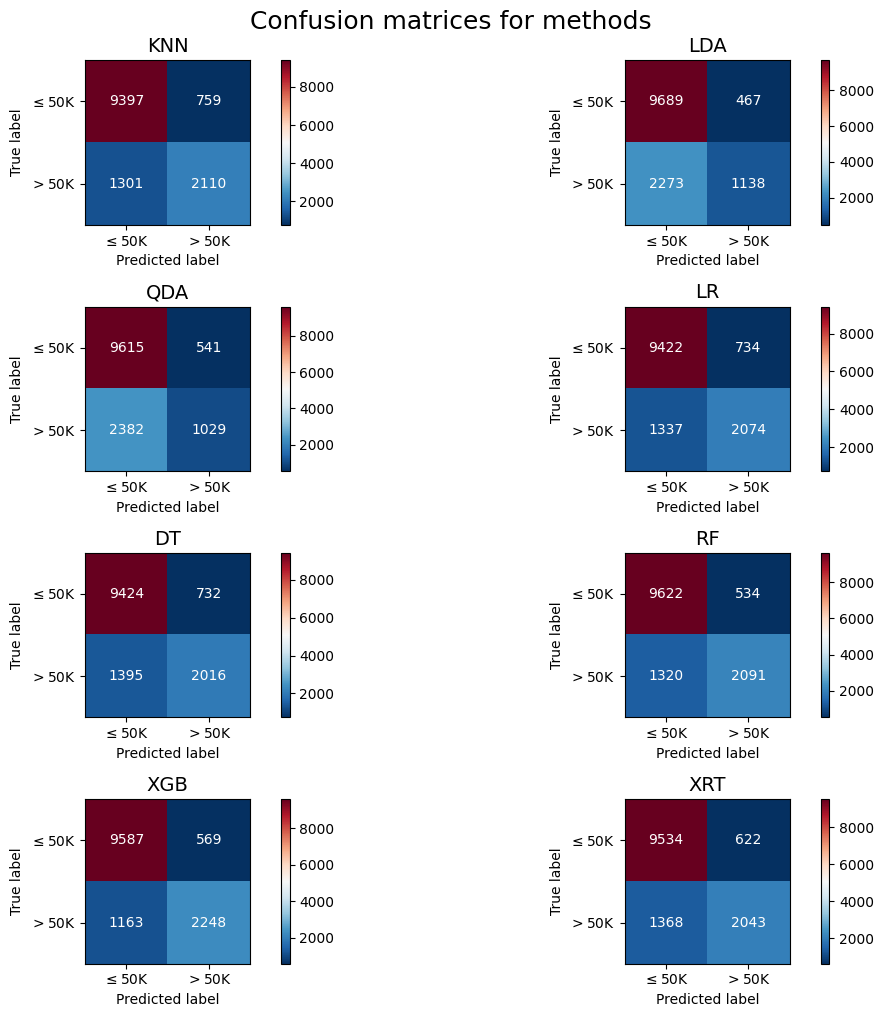

In [24]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(12, 10))

for i in tqdm(range(len(models)), desc="Scoring performance"):
    if names[i] == "LDA" or names[i] == "QDA":
        y_pred = models[i].fit(X_train[numeric_features], y_train).predict(X_test[numeric_features])
    else:
        y_pred = models[i].fit(X_train, y_train).predict(X_test)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax.ravel()[i], cmap="RdBu_r", text_kw={"color": "w"}, display_labels=[r"$\leq$50K", r"$>$50K"])
    ax.ravel()[i].set_title(names[i], size=14)

ax[0, 0].figure.text(0.6, 1.0, "Confusion matrices for methods", ha="center", va="center", size=18)
plt.tight_layout()
plt.savefig("plots/confusion.pdf", bbox_inches="tight")
plt.show()

Scoring performance:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring performance: 100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


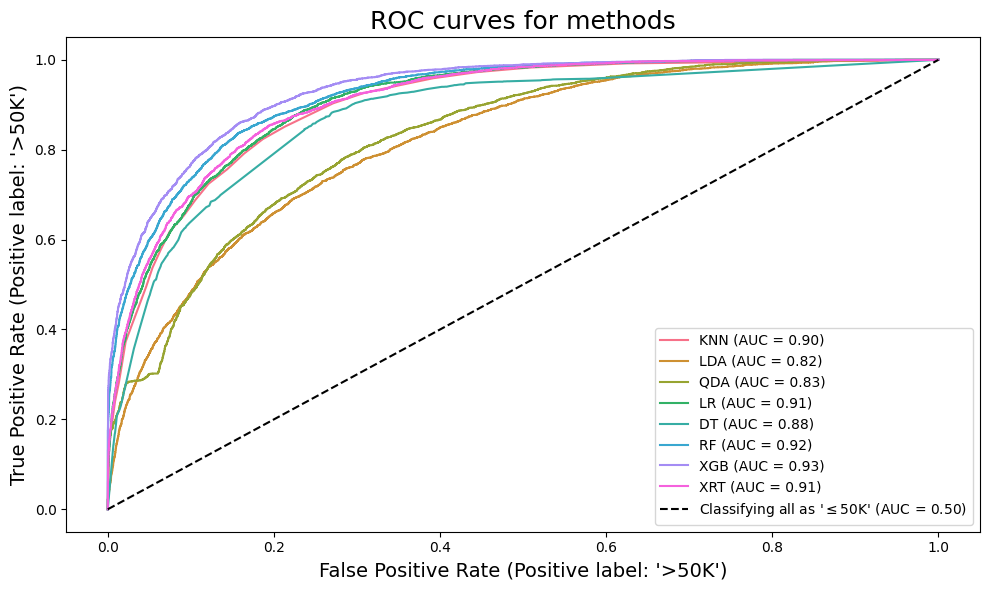

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in tqdm(range(len(models)), desc="Scoring performance"):
    if names[i] == "LDA" or names[i] == "QDA":
        clf = models[i].fit(X_train[numeric_features], y_train)
        RocCurveDisplay.from_estimator(clf, X_test[numeric_features], y_test, 
                                       ax=ax, name=names[i], 
                                       color=sns.color_palette("husl", len(names))[i])
    else:
        clf = models[i].fit(X_train, y_train)
        RocCurveDisplay.from_estimator(clf, X_test, y_test, 
                                       ax=ax, name=names[i], 
                                       color=sns.color_palette("husl", len(names))[i])

dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
RocCurveDisplay.from_estimator(dummy_clf, X_test, y_test, ax=ax, 
                               name=r"Classifying all as '$\leq$50K'", 
                               color="k", linestyle="--")


ax.set_title("ROC curves for methods", size=18)
ax.set_xlabel("False Positive Rate (Positive label: '>50K')", size=14)
ax.set_ylabel("True Positive Rate (Positive label: '>50K')", size=14)

plt.tight_layout()
plt.savefig("plots/roc.pdf", bbox_inches="tight")
plt.show()


Scoring performance: 100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


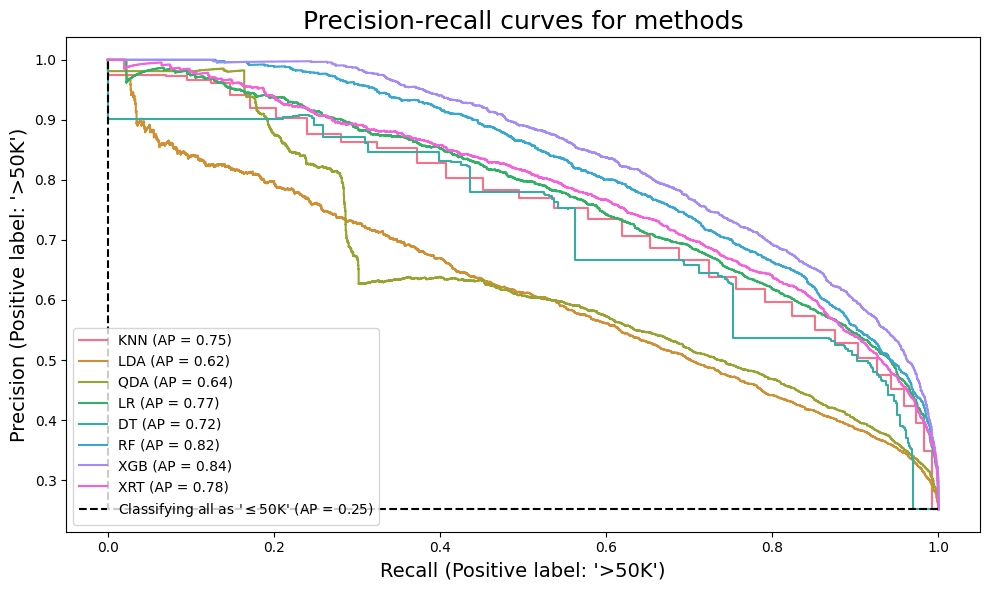

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in tqdm(range(len(models)), desc="Scoring performance"):
    if names[i] == "LDA" or names[i] == "QDA":
        clf = models[i].fit(X_train[numeric_features], y_train)
        PrecisionRecallDisplay.from_estimator(clf, X_test[numeric_features], y_test, 
                                              ax=ax, name=names[i], 
                                              color=sns.color_palette("husl", len(names))[i])
    else:
        clf = models[i].fit(X_train, y_train)
        PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, 
                                              ax=ax, name=names[i], 
                                              color=sns.color_palette("husl", len(names))[i])

dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
PrecisionRecallDisplay.from_estimator(dummy_clf, X_test, y_test, ax=ax, 
                                      name=r"Classifying all as '$\leq$50K'", 
                                      color="k", linestyle="--")


ax.set_title("Precision-recall curves for methods", size=18)
ax.set_xlabel("Recall (Positive label: '>50K')", size=14)
ax.set_ylabel("Precision (Positive label: '>50K')", size=14)
plt.tight_layout()
plt.savefig("plots/prc.pdf", bbox_inches="tight")
plt.show()
